<a href="https://colab.research.google.com/github/nagelex/dataa/blob/main/Classes_05_KNN_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear regressors: KNN and Decision Tree

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.preprocessing import power_transform

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
# constans
test_size=0.2
random_state=42

In [ ]:
def compute_score(y_true, y_pred):
  '''
  Helper function for printing scores.

  Parameters:
  y_true: ndarray of y values from original dataset.
  y_pred: ndarray of y values predicted with given model.

  Return:
  dictionary object that consists of R2 and median absolute error scores.

  '''
  return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedianAE": f"{median_absolute_error(y_true, y_pred):.3f}",
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_prediction_error(y_test, y_pred, scores):
  _, ax = plt.subplots(figsize=(5, 5))

  y_test = y_test.to_numpy() if isinstance(y_test, pd.DataFrame) else y_test

  display_ = PredictionErrorDisplay.from_predictions(
      y_test,
      y_pred,
      kind="actual_vs_predicted",
      ax=ax,
      scatter_kwargs={"alpha": 0.5}
  )

  ax.set_title("Linear model")
  for name, score in scores.items():
      ax.plot([], [], " ", label=f"{name}: {score}")
  ax.legend(loc="upper left")
  plt.tight_layout()

## Load dataset

In [ ]:
df = pd.read_csv('data_neo-ffi_religion.csv')
df.head()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
0,34.082439,46.043690,40.788554,461.110426,43.865868,2.838143,13.283297,3.744990,6.093860,4.458938
1,45.914894,45.968433,41.235290,401.384274,28.027017,3.824136,9.923179,3.392507,5.230517,3.269949
2,33.008654,42.065841,42.069170,390.193510,41.023889,2.288471,10.675467,3.765416,4.801786,4.683288
3,56.112153,45.903571,53.080369,468.518727,20.018578,5.824989,13.750513,2.826005,2.592473,0.883451
4,31.972346,49.009174,42.161417,508.686847,43.026028,4.038579,15.431653,4.689029,4.916692,4.627536


Inspect the dataset

In [ ]:
df.describe()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,37.811238,42.318673,41.208357,436.675828,36.042290,3.880765,31.980561,4.883313,5.299550,4.223002
std,8.871624,7.222606,8.104708,63.642560,11.014191,1.259730,100.373810,0.778776,0.944093,1.392345
min,14.040682,21.008399,16.904128,289.257541,12.942666,0.876634,2.262785,1.304512,1.905408,0.801310
25%,32.079634,37.959417,35.084398,388.849925,27.908735,3.046971,5.510436,4.430331,4.729321,3.169300
50%,38.954182,43.089033,41.052187,440.203497,35.908038,3.762668,11.153706,4.922857,5.437686,4.434408
75%,43.946449,47.078293,47.089308,480.501705,44.692161,4.684792,28.066035,5.373428,5.981834,5.213640
max,56.882820,59.121317,59.000430,572.957659,60.030339,6.935906,1250.740428,6.877499,7.139185,7.151545


## K-Nearest Neighbours

Recall the model from the last classes:

*Orthodoxy ~ Extraversion + Agreeableness + Openness + Neuroticism + Conscientiousness*

So far, we modeled this relationship using linear regression. Let's take a look at how the non-linear estimator - KNN will manage to model this relationship.

To create a model with KNN estimator, you simply need to create an object of type [`KNeighborsRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) instead of the linear regression object. Give yourself a moment to read the documentation of KNN regressor.

### Exercise 1
Let's compare the performance of KNN to the linear model.

1. The first model is the simplest linear model we have already done - without transformation of our exponential y

In [ ]:
# Linear regression model - for comparison
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of linear regression estimator
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.058', 'MedianAE': '21.663'}

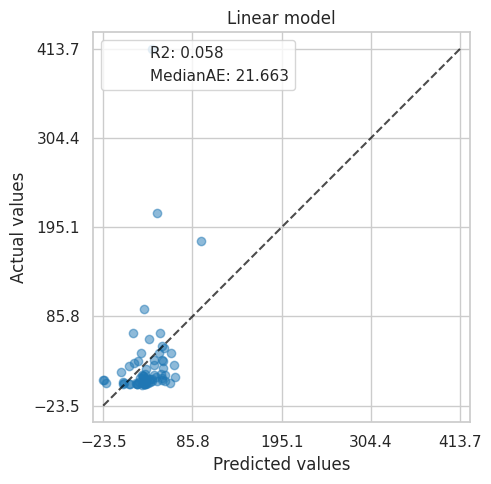

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

2. Linear model with y transformation (so that y has a more Gaussian-like distribution) - the best model we have already created:

In [ ]:
# Linear regression model - for comparison
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

y_transformed = power_transform(y, method='box-cox')

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=test_size, random_state=random_state)

# create object of linear regression estimator
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.268', 'MedianAE': '0.751'}

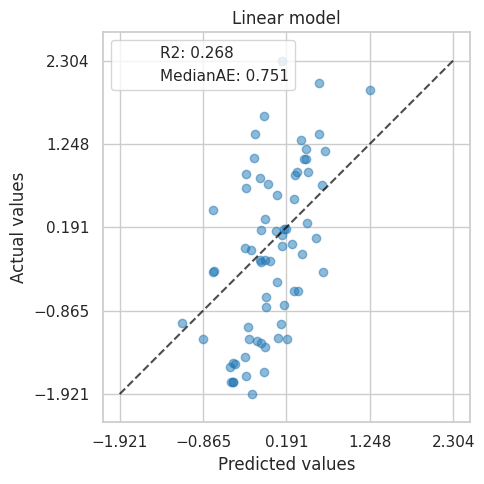

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

3. KNN Regressor model with default parameters (and no transformations at all):

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor() #n = 5 z automatu # mae nie możemy porównac ze sobą

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.314', 'MedianAE': '9.242'}

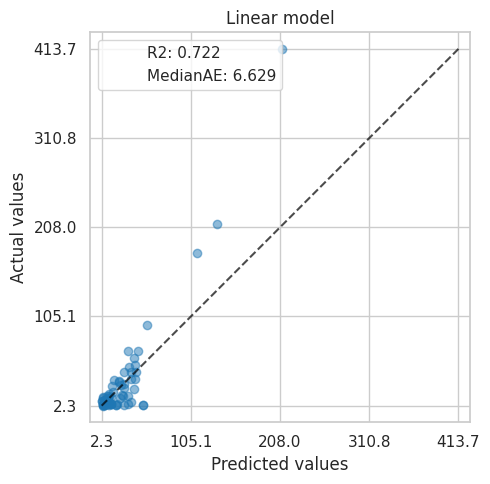

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

There is a huge difference! We didn't have to do anything - with zero knowledge of the data, we got a better result than using linear regression and all our knowledge of the data.

### Exercise 2
Now - try to play a little bit with KNN. Maybe you can extract even more from the model by changing its parameters?

Create at least 3 different KNN  and change at leat 2 different parameters.

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor() #n = 5 z automatu # mae nie możemy porównac ze sobą

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores




{'R2': '-0.611', 'MedianAE': '8.089'}

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor(p=2) #n = 5 z automatu # mae nie możemy porównac ze sobą

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.314', 'MedianAE': '9.242'}

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor(weights= 'distance')

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.912', 'MedianAE': '2.846'}

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor(algorithm = 'ball_tree') #n = 5 z automatu # mae nie możemy porównac ze sobą

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.314', 'MedianAE': '9.242'}

### (Exercise 2.1)

Too complex models tend to overfit, i.e., they are too closely matched to the training data and begin to perform poorly on the test data.
Plot training and testing performance vs number of neighbors to see, whether this model tends to overfit when the number of neighbors increases.

In [ ]:
# Your code here


What do you think this chart means for the problem of predicting orthodoxy based on personality traits? How many people with similar personality profiles is it best to look at to make a good prediction of the level of orthodoxy?

## Decision Trees

Now, we are going to create our model

*Orthodoxy ~ Extraversion + Agreeableness + Openness + Neuroticism + Conscientiousness*

using decision trees and compare this model to linear regression and KNN. Lets's take a look on the simples DT model.

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of DT estimator
dt =  DecisionTreeRegressor( criterion = 'absolute_error')

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.242', 'MedianAE': '2.794'}

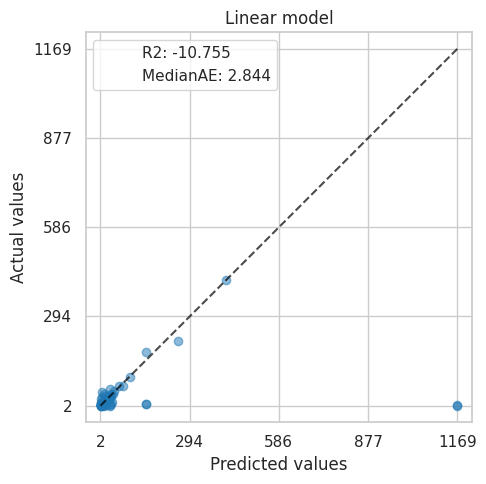

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

Ups! Something clearly is wrong. Does this graph remind you of anything?

### Exercise 3
Create the model with DT estimator, but before fitting, transform y to have more Gaussian-like distribution.

With KNNs exponential `y` wasn't a problem because the only thing KNN looked at was y value of nearest neighbors. DTs try to find the best-dividing lines for the data by assessing the quality of these divisions using the cost functions (and these functions base on the data variance). We need to 'fix' our variances - make them more comparable so that we can realize the full potential of decision trees.  

Create the model with a decision tree estimator, but transform `y` before the train-test split.

In [ ]:
# Your code here
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]
y = df[['Orthodoxy']]

df_transformed = df.copy()

y_transformed = power_transform(y, method = 'box-cox')

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=test_size, random_state=random_state)

# create object of DT estimator
dt =  DecisionTreeRegressor( criterion = 'absolute_error')

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.368', 'MedianAE': '0.151'}

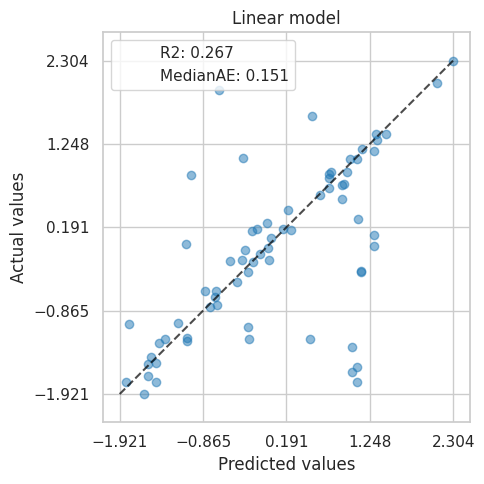

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

### (Exercise 3.1)

Decision trees have a lot of adjustable parameters. Especially interesting are: `criterion`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. Read about them in the documentation (and in the internet) and see how the performance of the model changes with the change of various parameters. You may want to create a graph of performance from model complexity to see if decision trees overfit easily.

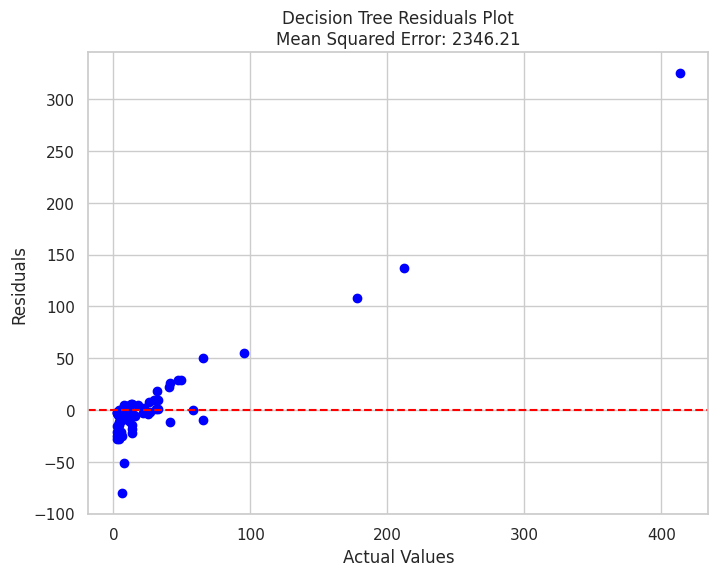

In [ ]:
#
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_test - y_pred

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Plotting the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title(f'Decision Tree Residuals Plot\nMean Squared Error: {mse:.2f}')
plt.show()

#  The red dashed line represents where the residuals would be if the model perfectly predicted the target variable

### Exercise 4

And now - the most interesting thing! We can analyze the structure of our fitted decision tree. We have to save the tree into `.dot` file and then we can use the [WebGraphviz](http://www.webgraphviz.com) tool to visualize the tree. You should copy the content of the `.dot` file (saved to the *Files* directory in Colab) to the input area on the [WebGraphviz](http://www.webgraphviz.com).

In [ ]:
from sklearn.tree import export_graphviz
# export the decision tree model to a tree_structure.dot file
# paste the contents of the file to webgraphviz.com
export_graphviz(
    dt,
    out_file ='tree_structure.dot',
    feature_names = X.columns.to_numpy()
)

Do the conclusions drawn from the linear regression coincide with DT?

## Homework: Comaprison of linear regression, KNN and Decision Tree

Check the effect of scaling and data transformation on Gaussian distributions on the performance of all three models.
* Models can be compared e.g., in three places: raw dataset, after y-transformation and after X-scaling;
* Create a visual comparison for all three estimators;
* Compare the models' estimated parameters (or structures) to see if the interpretation of the model has changed. For KNN, you can use [`kneighbors()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.kneighbors) method that returns neighbors of a given (of your choice) sample (of course these neighbors are from the training dataset). [`kneighbors()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.kneighbors) returns the distance of input point from each of n neighbors and indexes of those neighbors. You can always select these samples from the `X_train` dataset to see if your point and its neighbors are indeed closely related.

In [ ]:
def compute_score(y_true, y_pred):
  '''
  Helper function for printing scores.

  Parameters:
  y_true: ndarray of y values from original dataset.
  y_pred: ndarray of y values predicted with given model.

  Return:
  dictionary object that consists of R2 and median absolute error scores.

  '''
  return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedianAE": f"{median_absolute_error(y_true, y_pred):.3f}",
  }

Linear Regression Coefficients (raw): [[ 1.26106418  1.53663101  1.16528004 -0.20535222  0.9771728 ]]
Linear Regression Intercept(raw): [-73.90438483]


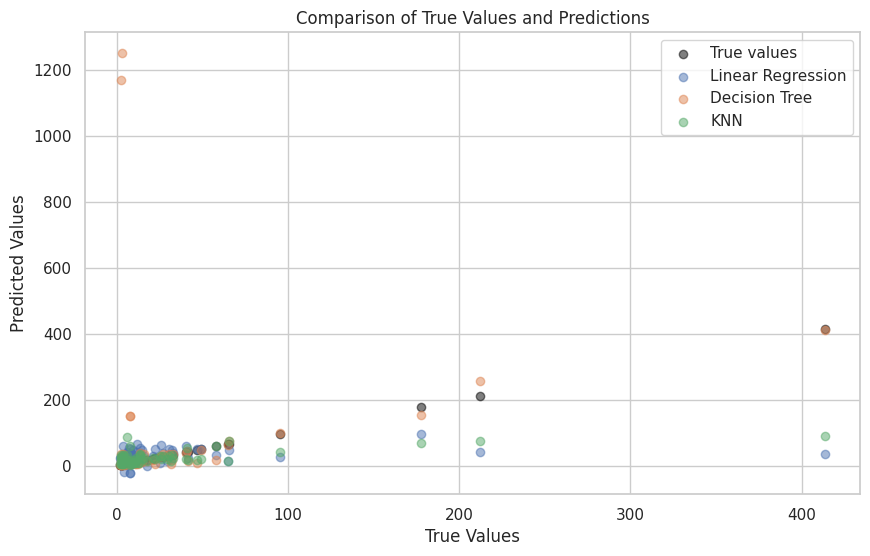

Linear Regression Coefficients (y-tr):  [[ 0.01940252  0.02083182  0.00865442 -0.00621302  0.01057038]]
Linear Regression Intercept(y-tr): [0.35271736]


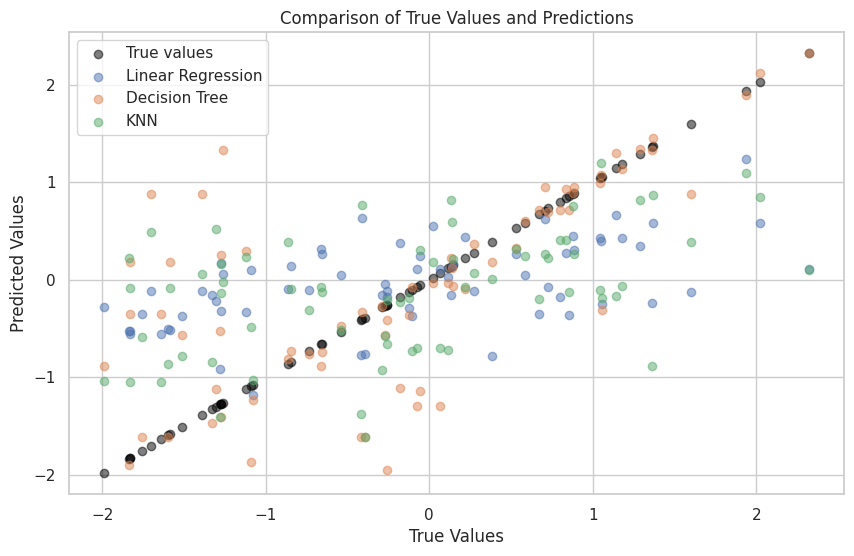

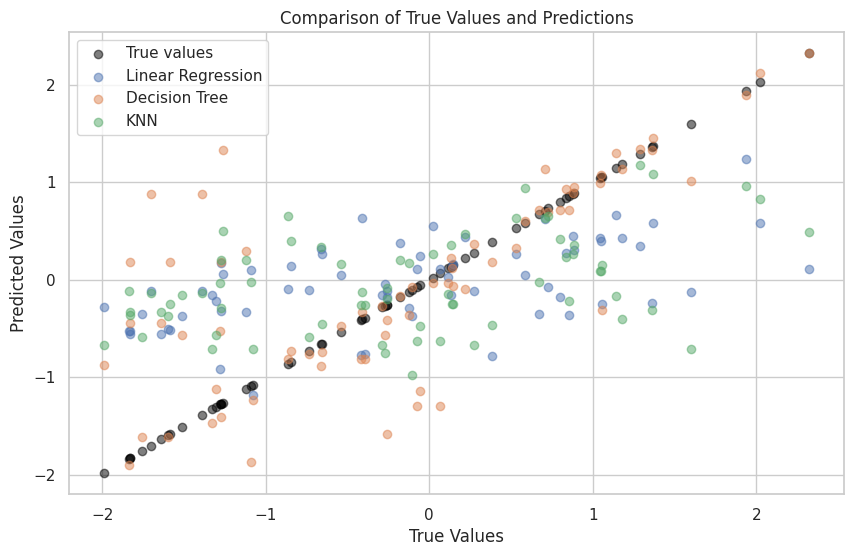

Linear Regression Coefficients(final): [[ 0.17134582  0.15197565  0.06961472 -0.3887577   0.11642708]]
Linear Regression Intercept(final): [-6.00334307e-16]


In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error

X = df[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Openness', 'Neuroticism']].to_numpy()
y = df[['Orthodoxy']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

linear_reg = linear_model.LinearRegression()
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor()


def plot_comparison(y_true, y_preds, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_true, label='True values', color='black', alpha=0.5)
    for y_pred, label in zip(y_preds, labels):
        plt.scatter(y_true, y_pred, label=label, alpha=0.5)
    plt.legend()
    plt.title('Comparison of True Values and Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()


#training the model on different dataset versions
#1 raw data
linear_reg.fit(X_train, y_train)
dt.fit(X_train, y_train)
knn.fit(X_train, y_train)

y_pred11 =linear_reg.predict(X_test)
y_pred12 = dt.predict(X_test)
y_pred13 = knn.predict(X_test)

print("Linear Regression Coefficients (raw):", linear_reg.coef_)
print("Linear Regression Intercept(raw):", linear_reg.intercept_)

scores_raw = {
    "Linear Regression": compute_score(y_test, y_pred11),
    "Decision Tree": compute_score(y_test, y_pred12),
    "KNN": compute_score(y_test, y_pred13),
}

plot_comparison(y_test, [y_pred11, y_pred12, y_pred13], scores_raw.keys())

# Transform y
pt = PowerTransformer(method='box-cox')
y_train_transformed = pt.fit_transform(y_train)
y_test_transformed = pt.transform(y_test)


#2 after y transformation
linear_reg.fit(X_train, y_train_transformed)
dt.fit(X_train, y_train_transformed)
knn.fit(X_train, y_train_transformed)

y_pred21 =linear_reg.predict(X_test)
y_pred22 = dt.predict(X_test)
y_pred23 = knn.predict(X_test)

print("Linear Regression Coefficients (y-tr): ", linear_reg.coef_)
print("Linear Regression Intercept(y-tr):", linear_reg.intercept_)

scores_transformed = {
    "Linear Regression": compute_score(y_test_transformed, y_pred21),
    "Decision Tree": compute_score(y_test_transformed, y_pred22),
    "KNN": compute_score(y_test_transformed, y_pred23),
}

plot_comparison(y_test_transformed, [y_pred21, y_pred22, y_pred23], scores_transformed.keys())

# Scale X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 after X scaling

linear_reg.fit(X_train_scaled, y_train_transformed)
dt.fit(X_train_scaled, y_train_transformed)
knn.fit(X_train_scaled, y_train_transformed)

y_pred31 =linear_reg.predict(X_test_scaled)
y_pred32 = dt.predict(X_test_scaled)
y_pred33 = knn.predict(X_test_scaled)

scores_scaled = {
    "Linear Regression": compute_score(y_test_transformed, y_pred31),
    "Decision Tree": compute_score(y_test_transformed, y_pred32),
    "KNN": compute_score(y_test_transformed, y_pred33),
}

plot_comparison(y_test_transformed, [y_pred31, y_pred32, y_pred33], scores_scaled.keys())

# Check model parameters or structures
# For linear regression, you can print coefficients and intercept
print("Linear Regression Coefficients(final):", linear_reg.coef_)
print("Linear Regression Intercept(final):", linear_reg.intercept_)


# from sklearn.tree import export_graphviz
# import graphviz
# dot_data = export_graphviz(dt, out_file=None, feature_names=['Extraversion', 'Agreeableness', 'Conscientiousness', 'Openness', 'Neuroticism'], filled=True, rounded=True)
# graph = graphviz.Source(dot_data)
# graph.render("decision_tree")

# # For KNN, kneighbors method

# sample_index = 0
# neighbors_indices = knn.kneighbors([X_train[sample_index]])[1]
# neighbors_indices2 = knn.kneighbors([X_train_scaled[sample_index]])[1]
# print("KNN Neighbors Indices for Sample 0:", neighbors_indices, neighbors_indices2)
# sample_index = 0

# # Raw Data Scenario
# neighbors_indices_raw = knn.kneighbors([X_train[sample_index]])[1]

# # X-Scaled Scenario
# neighbors_indices_x_scaled = knn.kneighbors([X_train_scaled[sample_index]])[1]

# print("KNN Neighbors Indices for Sample 0 (Raw Data):", neighbors_indices_raw)
# print("KNN Neighbors Indices for Sample 0 (X-Scaled):", neighbors_indices_x_scaled)

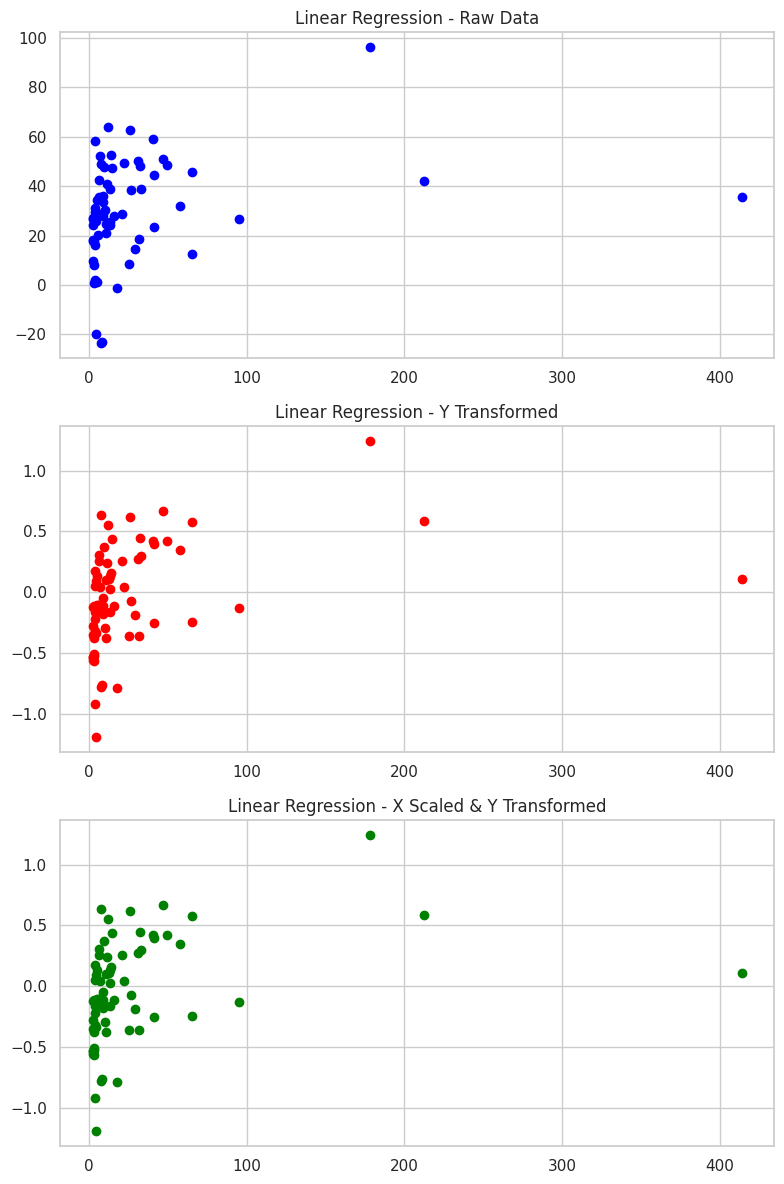

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))


axs[0].scatter(y_test, y_pred11, color='blue')
axs[0].set_title('Linear Regression - Raw Data')

axs[1].scatter(y_test, y_pred21, color='red')
axs[1].set_title('Linear Regression - Y Transformed')

axs[2].scatter(y_test, y_pred31, color='green')
axs[2].set_title('Linear Regression - X Scaled & Y Transformed')

plt.tight_layout()
plt.show()


In [ ]:
fig, axs_dt = plt.subplots(3, 1, figsize=(8, 12))

# Plot for raw data
axs_dt[0].scatter(y_test, y_pred12, color='blue')
axs_dt[0].set_title('Decision Tree - Raw Data')

# Plot for y-transformed data
axs_dt[1].scatter(y_test, y_pred22, color='red')
axs_dt[1].set_title('Decision Tree - Y Transformed')

# Plot for X-scaled and y-transformed data
axs_dt[2].scatter(y_test, y_pred32, color='green')
axs_dt[2].set_title('Decision Tree - X Scaled & Y Transformed')

plt.tight_layout()
plt.show()


In [ ]:
fig, axs_knn = plt.subplots(3, 1, figsize=(8, 12))

axs_knn[0].scatter(y_test, y_pred13, color='blue')
axs_knn[0].set_title('K-Nearest Neighbors - Raw Data')

axs_knn[1].scatter(y_test, y_pred23, color='red')
axs_knn[1].set_title('K-Nearest Neighbors - Y Transformed')

axs_knn[2].scatter(y_test, y_pred33, color='green')
axs_knn[2].set_title('K-Nearest Neighbors - X Scaled & Y Transformed')

plt.tight_layout()
plt.show()


                 Scenario Linear Regression Decision Tree    KNN
0                Raw Data             0.058       -12.434  0.314
1  After Y-Transformation             0.268         0.440  0.195
2         After X-Scaling             0.268         0.428  0.176


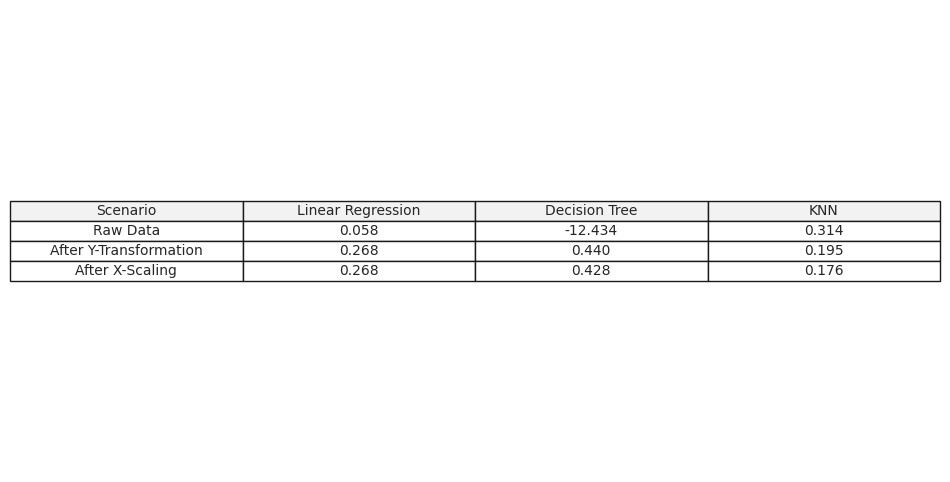

In [ ]:
# Create a DataFrame to store R2 scores
data = {
    'Scenario': [],
    'Linear Regression': [],
    'Decision Tree': [],
    'KNN': [],
}

# Helper function to append scores to the DataFrame
def append_scores(scenario, model_scores):
    data['Scenario'].append(scenario)
    data['Linear Regression'].append(model_scores['Linear Regression']['R2'])
    data['Decision Tree'].append(model_scores['Decision Tree']['R2'])
    data['KNN'].append(model_scores['KNN']['R2'])

# 1. Raw Data
append_scores('Raw Data', scores_raw)

# 2. After Y-Transformation
append_scores('After Y-Transformation', scores_transformed)

# 3. After X-Scaling
append_scores('After X-Scaling', scores_scaled)

# Create a DataFrame from the data dictionary
df_r2_comparison = pd.DataFrame(data)

# Print the comparison table
print(df_r2_comparison)

# Save the comparison table as an image
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axis for better visualization
table = ax.table(cellText=df_r2_comparison.values, colLabels=df_r2_comparison.columns, loc='center', cellLoc='center', colColours=['#f2f2f2']*df_r2_comparison.shape[1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the table size

plt.savefig('r2_comparison.png', bbox_inches='tight')
plt.show()

                 Scenario Linear Regression R2 Decision Tree R2 KNN R2  \
0                Raw Data                0.058          -12.434  0.314   
1  After Y-Transformation                0.268            0.440  0.195   
2         After X-Scaling                0.268            0.428  0.176   

  Linear Regression MAE Decision Tree MAE KNN MAE  
0                21.663             3.015   9.242  
1                 0.766             0.144   0.643  
2                 0.766             0.154   0.739  


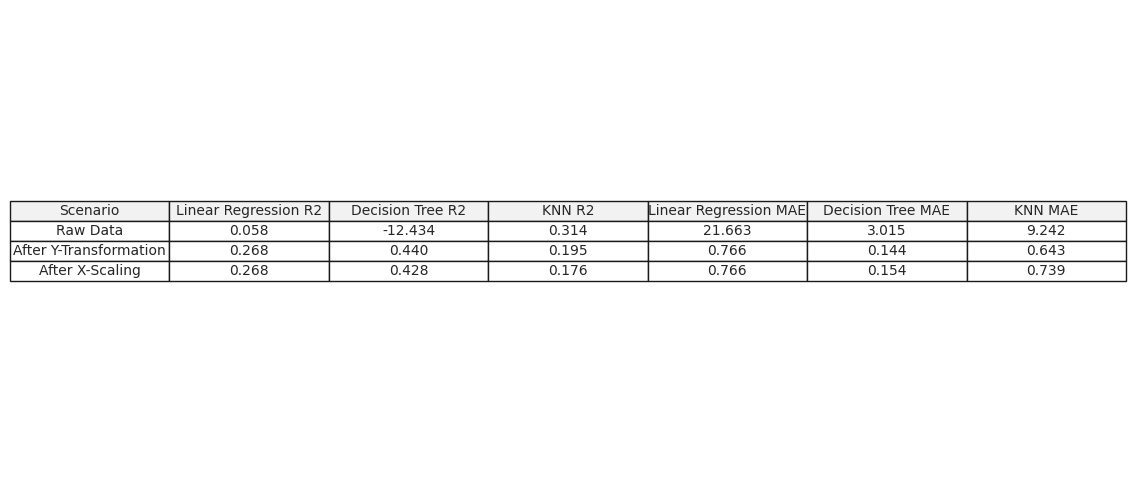

In [ ]:
data = {
    'Scenario': [],
    'Linear Regression R2': [],
    'Decision Tree R2': [],
    'KNN R2': [],
    'Linear Regression MAE': [],
    'Decision Tree MAE': [],
    'KNN MAE': [],
}

# Helper function to append scores to the DataFrame
def append_scores(scenario, model_scores):
    data['Scenario'].append(scenario)
    data['Linear Regression R2'].append(model_scores['Linear Regression']['R2'])
    data['Decision Tree R2'].append(model_scores['Decision Tree']['R2'])
    data['KNN R2'].append(model_scores['KNN']['R2'])
    data['Linear Regression MAE'].append(model_scores['Linear Regression']['MedianAE'])
    data['Decision Tree MAE'].append(model_scores['Decision Tree']['MedianAE'])
    data['KNN MAE'].append(model_scores['KNN']['MedianAE'])

# 1. Raw Data
append_scores('Raw Data', scores_raw)

# 2. After Y-Transformation
append_scores('After Y-Transformation', scores_transformed)

# 3. After X-Scaling
append_scores('After X-Scaling', scores_scaled)

# Create a DataFrame from the data dictionary
df_comparison = pd.DataFrame(data)

# Print the comparison table
print(df_comparison)

# Save the comparison table as an image
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')  # Turn off axis for better visualization
table = ax.table(cellText=df_comparison.values, colLabels=df_comparison.columns, loc='center', cellLoc='center', colColours=['#f2f2f2']*df_comparison.shape[1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the table size

plt.savefig('r2_mae_comparison.png', bbox_inches='tight')
plt.show()

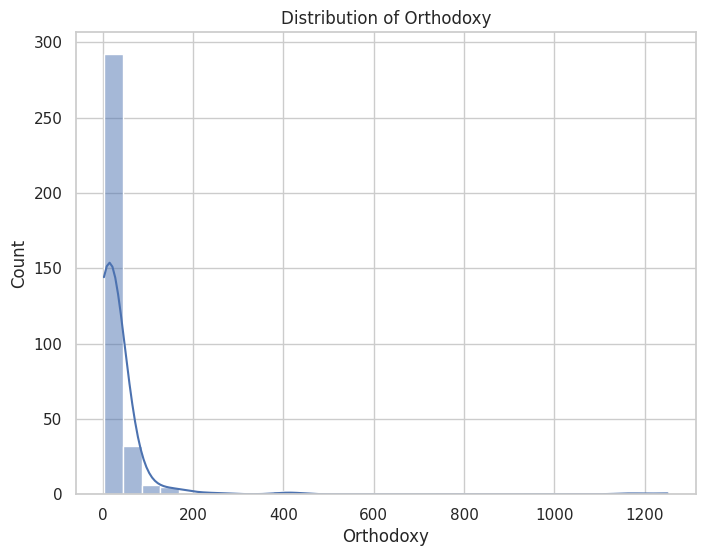

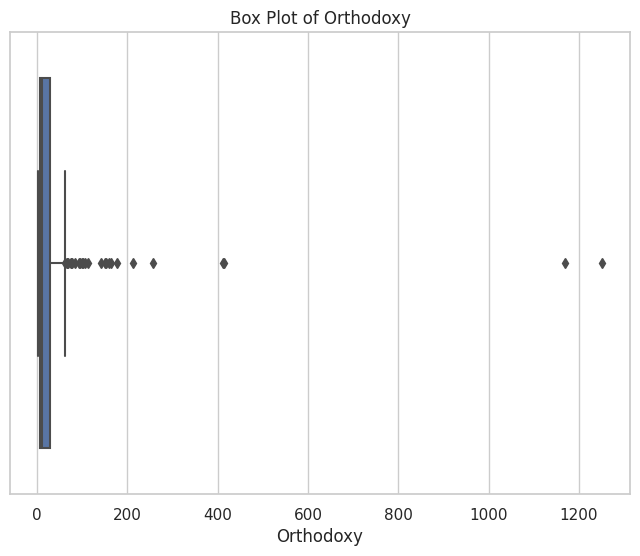

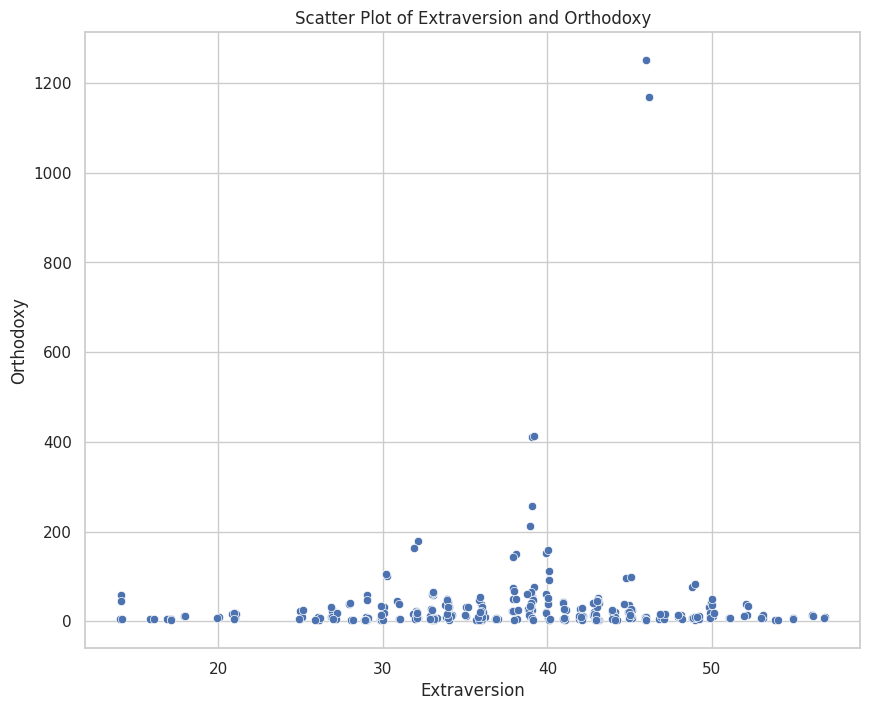

Polynomial Regression Scores: {'R2': '0.009', 'MedianAE': '23.450'}


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

# 1. Data Distribution and Outliers
# Example: Visualizing the distribution of 'Extraversion'
plt.figure(figsize=(8, 6))
sns.histplot(df['Orthodoxy'], bins=30, kde=True)
plt.title('Distribution of Orthodoxy')
plt.show()

# Example: Box plot for the target variable 'Orthodoxy'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Orthodoxy'])
plt.title('Box Plot of Orthodoxy')
plt.show()

# 2. Non-Linear Relationships
# Example: Scatter plot for 'Extraversion' and 'Orthodoxy'
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['Extraversion'], y=df['Orthodoxy'])
plt.title('Scatter Plot of Extraversion and Orthodoxy')
plt.show()

# 3. Explore Complex Models
# Example: Training a Polynomial Regression model
degree = 2  # adjust the degree as needed
model_poly = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
model_poly.fit(df[['Extraversion']], df['Orthodoxy'])
y_pred_poly = model_poly.predict(df[['Extraversion']])

# Evaluate the model and compare with linear regression
score_poly = compute_score(df['Orthodoxy'], y_pred_poly)
print("Polynomial Regression Scores:", score_poly)

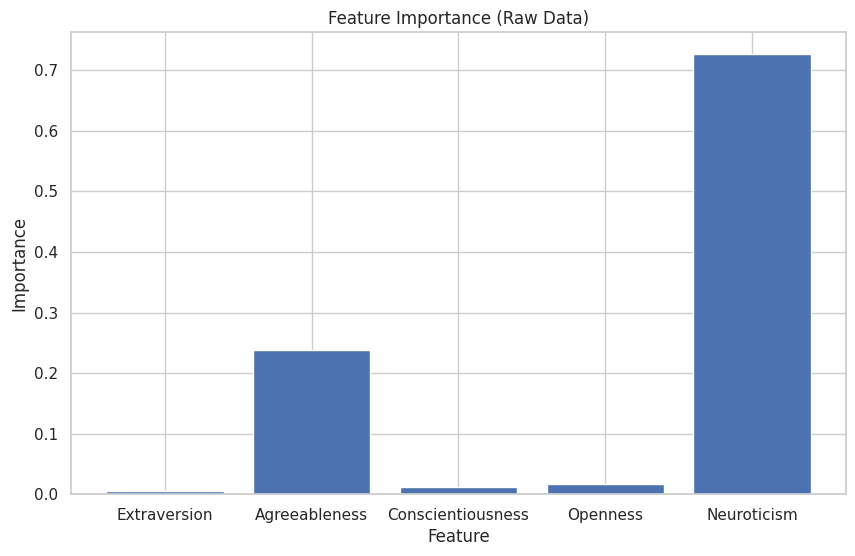

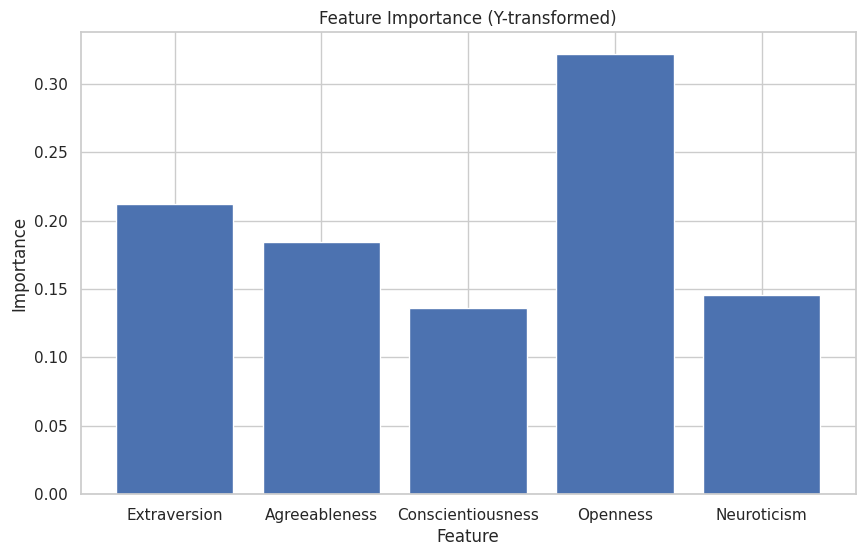

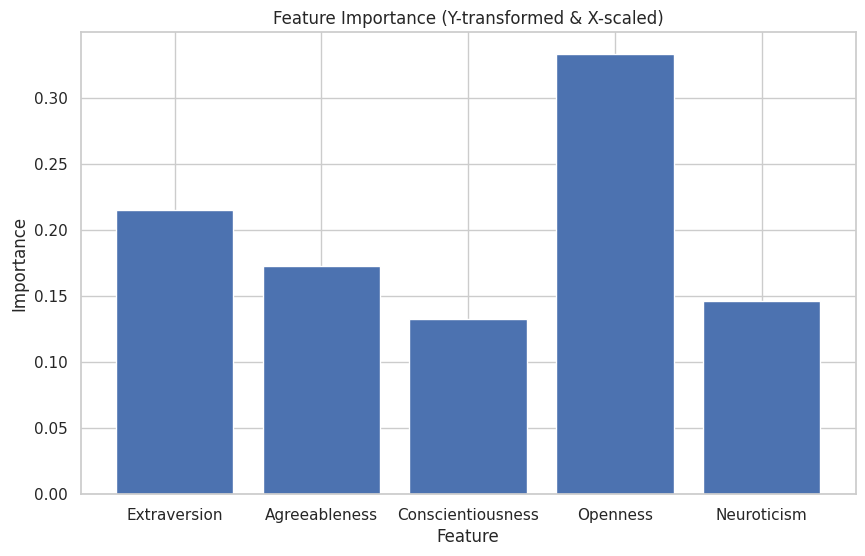

In [ ]:
dt = DecisionTreeRegressor()

# Fit on Raw Data
dt.fit(X_train, y_train)
feature_importances_raw = dt.feature_importances_

# Fit on Y-transformed Data
pt = PowerTransformer(method='box-cox')
y_train_transformed = pt.fit_transform(y_train)
dt.fit(X_train, y_train_transformed)
feature_importances_y_transformed = dt.feature_importances_

# Fit on Y-transformed & X-scaled Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
dt.fit(X_train_scaled, y_train_transformed)
feature_importances_y_scaled = dt.feature_importances_

# Get feature names
feature_names = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Openness', 'Neuroticism']

# Plot feature importances for Raw Data
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Raw Data)")
plt.bar(range(len(feature_names)), feature_importances_raw, align="center")
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Plot feature importances for Y-transformed Data
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Y-transformed)")
plt.bar(range(len(feature_names)), feature_importances_y_transformed, align="center")
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Plot feature importances for Y-transformed & X-scaled Data
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Y-transformed & X-scaled)")
plt.bar(range(len(feature_names)), feature_importances_y_scaled, align="center")
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()